# Implementation of PCA

Content credit: The case study used in this notebook has been prepared by the teaching staff of Berkeley's Data Science 100 class.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from datetime import datetime

np.random.seed(23) #kallisti

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

## Congressional Vote Data

In this case study we examine how the House of Representatives (of the 116th Congress, 1st session) voted in the month of **September 2019**.

From the [U.S. Senate website](https://www.senate.gov/reference/Index/Votes.htm):

> Roll call votes occur when a representative or senator votes "yea" or "nay," so that the names of members voting on each side are recorded. A voice vote is a vote in which those in favor or against a measure say "yea" or "nay," respectively, without the names or tallies of members voting on each side being recorded.

The data, compiled from ProPublica [source](https://github.com/eyeseast/propublica-congress), is a "skinny" table of data where each record is a single vote by a member across any roll call in the 116th Congress, 1st session, as downloaded in February 2020. The member of the House, whom we'll call **legislator**, is denoted by their bioguide alphanumeric ID in http://bioguide.congress.gov/.

In [4]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
url_votes = 'https://raw.githubusercontent.com/ulischlickewei/Mathe2-DS/main/votes.csv'
votes = pd.read_csv(url_votes)
votes = votes.astype({"roll call": str})
votes

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No
...,...,...,...,...,...
17823,House,1,515,Y000062,Yes
17824,House,1,515,Y000065,No
17825,House,1,515,Y000033,Yes
17826,House,1,515,Z000017,Yes


## Task 1

Describe how the cell below transforms the data. You might be interested in looking up the [official tutorial for Pivot tables](https://pandas.pydata.org/docs/user_guide/reshaping.html) or the documentation of [`pivot_table()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).

In [5]:
def was_yes(s):
    return 1 if s.iloc[0] == "Yes" else 0

vote_pivot = votes.pivot_table(index='member',
                                columns='roll call',
                                values='vote',
                                aggfunc=was_yes,
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()

(441, 41)


roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,0,1
A000369,1,1,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1


**Solution**: We pivot the table to group each legislator and their voting pattern across every (roll call) vote in this month. We mark 1 if the legislator voted Yes (yea), and 0 otherwise (No/nay, no vote, speaker, etc.). This is done using the Pandas function `pivot_table()` with a custom aggregation function which simply takes the first entry of a Series and maps this to 0 or to 1 depending on whether the voting behaviour was "Yes" or "No"

**How do we analyze this data?**

While we could consider loading information about the legislator, such as their party, and see how this relates to their voting pattern, it turns out that we can do a lot with PCA to cluster legislators by how they vote.

## Task 2
Center the data by subtracting the mean from each feature.

In [6]:
vote_pivot_centered = vote_pivot - np.mean(vote_pivot, axis = 0)
vote_pivot_centered.head(5)

roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,0.129252,-0.668934,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000367,-0.870748,-0.668934,-0.526077,-0.52381,-0.950113,-0.412698,-0.562358,-0.365079,-0.405896,-0.439909,...,-0.521542,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,-0.913832,0.496599
A000369,0.129252,0.331066,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000370,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599
A000371,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599


## Task 3
Use the function `np.linalg.svd()` (see [documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)) to compute the singular value decomposition of the centered data matrix.

In [7]:
u, s, vt = np.linalg.svd(vote_pivot_centered, full_matrices = False)

## Task 4
If the first two singular values are large and all others are small, then two dimensions are enough to describe most of what distinguishes one observation from another. If not, then a PCA scatter plot is omitting lots of information.

An equivalent way to evaluate this is to determine the **variance ratios**, i.e., the fraction of the variance each PC contributes to total variance.

Compute the variance ratios for the centered Congressional Vote Data.

In [8]:
np.round(s**2 / sum(s**2), 2)

array([0.8 , 0.05, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

## Task 5
A [**scree plot**](https://en.wikipedia.org/wiki/Scree_plot) (and where its "elbow" is located) is a visual way of checking the distribution of variance. Technically, it simply consists of a [line plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) of the distribution of variance of the dataset.

Create a scree plot to visualize how much of the variance is explained by the first principal components of our dataset.

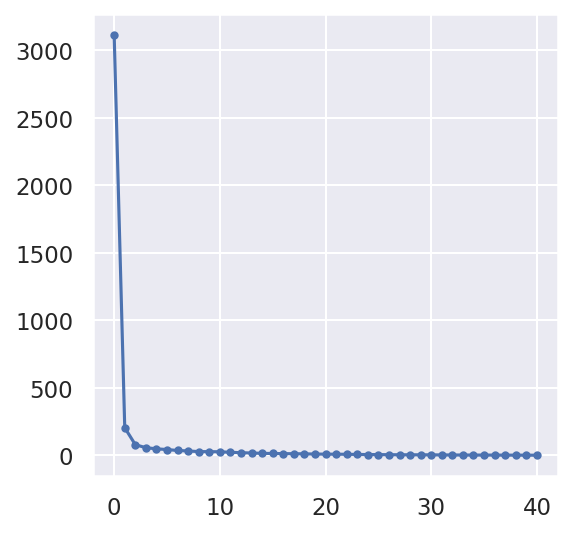

In [9]:
plt.plot(s**2, marker='.'); # square of singular values

## Task 6

Project the centered data to PC1 and PC2 and create a scatterplot of the projected data in $\mathbb{R}^2$.

In [10]:
pcs = u * s
projection = pcs[:,:2]

In [12]:
projection.shape

(441, 2)

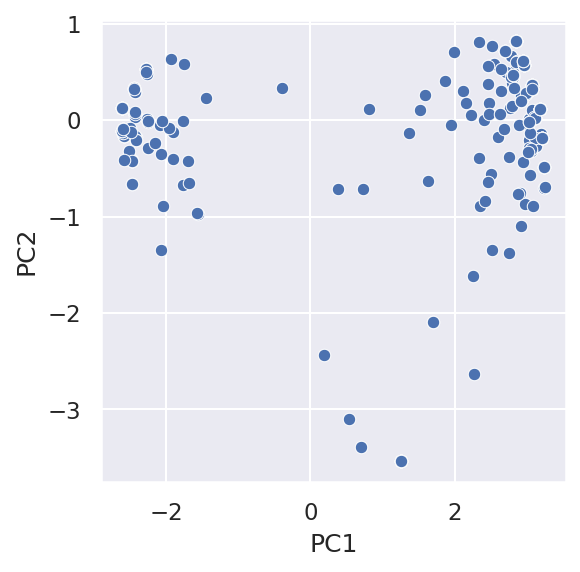

In [13]:
sns.scatterplot(x=projection[:,0], y=projection[:,1]);
plt.xlabel("PC1");
plt.ylabel("PC2");

Baesd on the plot above, it looks like there are two clusters of datapoints. What do you think this corresponds to?

## Task 7
Use [`sklearn.decomposition.PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to compute the PCA of the original congressional vote dataset and to project the dataset to the first two principal components. Then create the same scatterplot as in Task 6.

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
projection2 = pca.fit_transform(vote_pivot_centered)

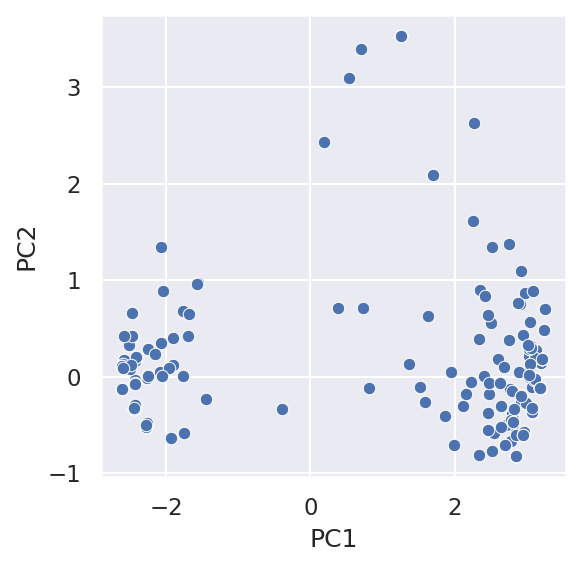

In [15]:
sns.scatterplot(x=projection2[:,0], y=projection2[:,1]);
plt.xlabel("PC1");
plt.ylabel("PC2");

## Incorporating Member Information

In the following we load in more member information, from https://github.com/unitedstates/congress-legislators. This includes each legislator's political party.

In [16]:
legislators_url = 'https://raw.githubusercontent.com/ulischlickewei/Mathe2-DS/main/legislators-current.yaml'
import requests
r = requests.get(legislators_url)
legislators_data = yaml.safe_load(r.content)

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'],
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.set_index("leg_id")
legs.sort_index()

,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05
3,C000174,Thomas,Carper,M,DE,sen,Democrat,1947-01-23
4,C001070,Robert,Casey,M,PA,sen,Democrat,1960-04-13
...,...,...,...,...,...,...,...,...
534,M001197,Martha,McSally,F,AZ,sen,Republican,1966-03-22
535,G000592,Jared,Golden,M,ME,rep,Democrat,1982-07-25
536,K000395,Fred,Keller,M,PA,rep,Republican,1965-10-23
537,B001311,Dan,Bishop,M,NC,rep,Republican,1964-07-01


Let's check out how party affiliations relate to the PC1, PC2 transformation from earlier:

In [17]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d[vote2d['pc1'] < 0]['party'].value_counts()

party
Democrat    231
Name: count, dtype: int64

## Task 8
Adapt your scatterplot from above by incorporating the party labels as colors for the projected dataset. Use the `hue` option for this.

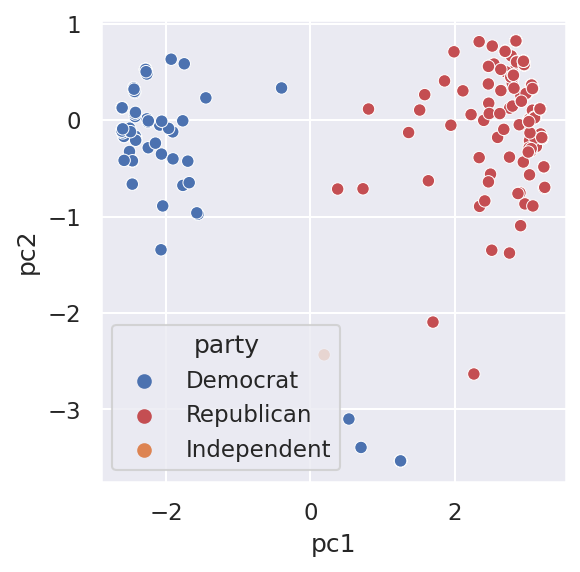

In [18]:
cp = sns.color_palette()
party_cp = [cp[i] for i in [0, 3, 1]]
party_hue = ["Democrat", "Republican", "Independent"]

sns.scatterplot(x="pc1", y="pc2",
                hue="party", palette=party_cp,  hue_order=party_hue,
                data = vote2d);